Found 2100 images belonging to 10 classes.
Found 600 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
🚀 Entrenando modelo DenseNet con train/val/test...
Epoch 1/30
210/210 [==============================] - 24s 64ms/step - loss: 2.1808 - accuracy: 0.3095 - val_loss: 1.0514 - val_accuracy: 0.6283
Epoch 2/30
210/210 [==============================] - 10s 50ms/step - loss: 0.9184 - accuracy: 0.6895 - val_loss: 0.6416 - val_accuracy: 0.7733
Epoch 3/30
210/210 [==============================] - 11s 51ms/step - loss: 0.4949 - accuracy: 0.8386 - val_loss: 0.5523 - val_accuracy: 0.8250
Epoch 4/30
210/210 [==============================] - 11s 50ms/step - loss: 0.2750 - accuracy: 0.9129 - val_loss: 0.5163 - val_accuracy: 0.8300
Epoch 5/30
210/210 [==============================] - 11s 53ms/step - loss: 0.1651 - accuracy: 0.9490 - val_loss: 0.3007 - val_accuracy: 0.9100
Epoch 6/30
210/210 [==============================] - 10s 48ms/step - loss: 0.1877 - accuracy: 0.9414 

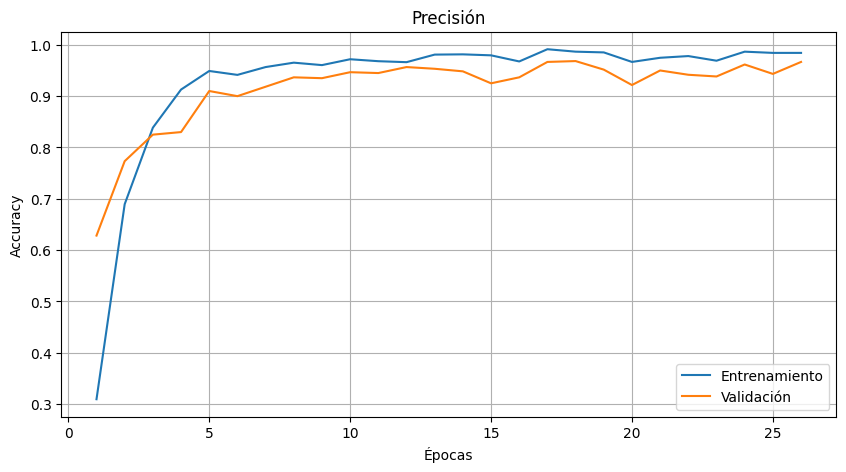

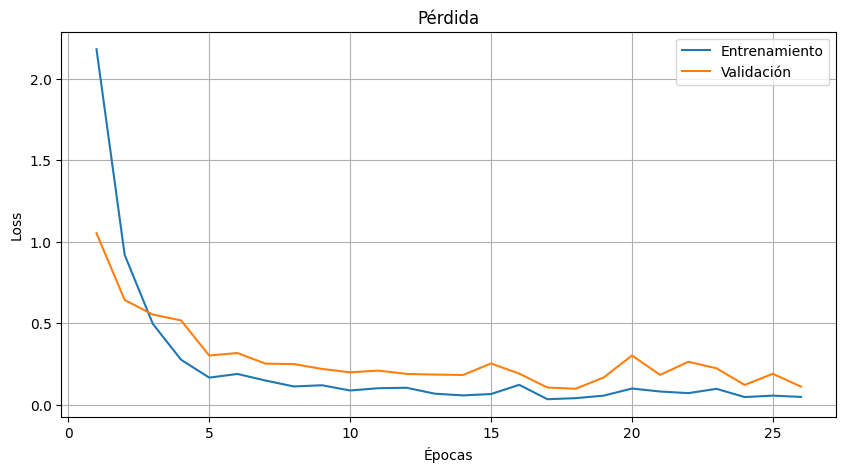

In [1]:
import os
import random
import pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# --- CONFIGURACIÓN ---
SEED = 42
IMG_SIZE = 224
BATCH_SIZE = 10
EPOCHS = 30
LEARNING_RATE = 1e-3
FINE_TUNE_LAST_N = 120
PATIENCE = 8

CLASS_NAMES = ['A','Am','B','C','D','Dm','E','Em','F','G']

# --- RUTAS ---
BASE_DIR = r"C:\Users\anton\Pictures\GuitarSet_Split"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR = os.path.join(BASE_DIR, "val")
TEST_DIR = os.path.join(BASE_DIR, "test")

OUT_DIR = r"C:\Users\anton\Pictures\Modelo_DenseNet_TrainValTestV1"
os.makedirs(OUT_DIR, exist_ok=True)

# --- SEMILLAS ---
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# --- FUNCIÓN PARA CARGAR DATASETS ---
def load_dataset(folder):
    return tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.densenet.preprocess_input
    ).flow_from_directory(
        folder,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=SEED
    )

# --- CARGA DE DATOS ---
train_ds = load_dataset(TRAIN_DIR)
val_ds = load_dataset(VAL_DIR)
test_ds = load_dataset(TEST_DIR)

# --- MODELO BASE ---
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
num_layers = len(base_model.layers)

# congelar capas excepto las últimas
for layer in base_model.layers[:num_layers - FINE_TUNE_LAST_N]:
    layer.trainable = False
for layer in base_model.layers[num_layers - FINE_TUNE_LAST_N:]:
    layer.trainable = True

# --- CABECERA ---
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
output = Dense(len(CLASS_NAMES), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

# --- COMPILACIÓN ---
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# --- CALLBACKS ---
best_model_path = os.path.join(OUT_DIR, "mejor_modelo.h5")
final_model_path = os.path.join(OUT_DIR, "modelo_final.h5")
hist_path = os.path.join(OUT_DIR, "historial.pkl")

early = EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights=True)
ckpt = ModelCheckpoint(best_model_path, monitor="val_accuracy", save_best_only=True)

# --- ENTRENAMIENTO ---
print("🚀 Entrenando modelo DenseNet con train/val/test...")

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early, ckpt]
)

# --- GUARDAR MODELO FINAL ---
model.save(final_model_path)

# --- GUARDAR HISTORIAL ---
with open(hist_path, "wb") as f:
    pickle.dump(history.history, f)

print("✅ Entrenamiento finalizado.")
print("📌 Modelo final guardado en:", final_model_path)
print("📌 Mejor modelo guardado en:", best_model_path)

# --- EVALUACIÓN EN TEST ---
test_loss, test_acc = model.evaluate(test_ds)
print(f"\n🎯 Precisión en TEST: {test_acc*100:.2f}%")
print(f"🎯 Pérdida en TEST: {test_loss:.4f}")

# --- GRAFICAR RESULTADOS ---
def plot_metrics(history_data, out_dir):
    acc = history_data['accuracy']
    val_acc = history_data['val_accuracy']
    loss = history_data['loss']
    val_loss = history_data['val_loss']
    epochs_range = range(1, len(acc)+1)

    # Accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(epochs_range, acc, label='Entrenamiento')
    plt.plot(epochs_range, val_acc, label='Validación')
    plt.title('Precisión')
    plt.xlabel('Épocas')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()
    plt.savefig(os.path.join(out_dir, "grafico_precision.png"))
    plt.show()

    # Loss
    plt.figure(figsize=(10, 5))
    plt.plot(epochs_range, loss, label='Entrenamiento')
    plt.plot(epochs_range, val_loss, label='Validación')
    plt.title('Pérdida')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    plt.savefig(os.path.join(out_dir, "grafico_perdida.png"))
    plt.show()

plot_metrics(history.history, OUT_DIR)


In [11]:
val_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.densenet.preprocess_input
)

val_ds = val_gen.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=False        # OBLIGATORIO
)


Found 600 images belonging to 10 classes.


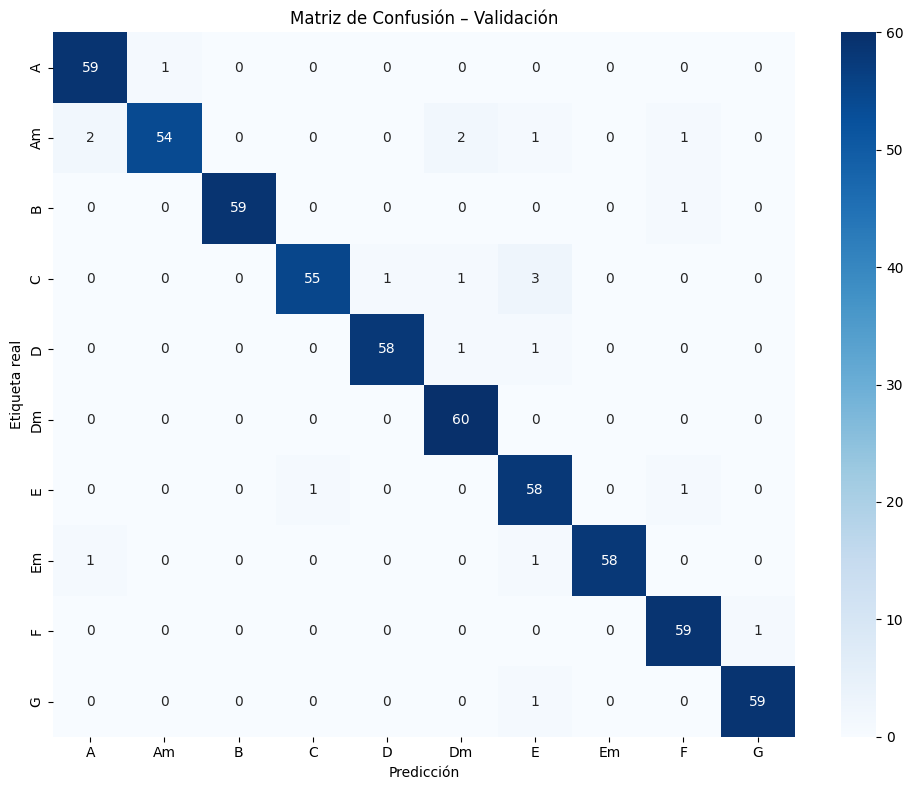

REPORTE DE CLASIFICACIÓN – VALIDACIÓN

              precision    recall  f1-score   support

           A       0.95      0.98      0.97        60
          Am       0.98      0.90      0.94        60
           B       1.00      0.98      0.99        60
           C       0.98      0.92      0.95        60
           D       0.98      0.97      0.97        60
          Dm       0.94      1.00      0.97        60
           E       0.89      0.97      0.93        60
          Em       1.00      0.97      0.98        60
           F       0.95      0.98      0.97        60
           G       0.98      0.98      0.98        60

    accuracy                           0.96       600
   macro avg       0.97      0.96      0.97       600
weighted avg       0.97      0.96      0.97       600



In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# ======================================================
# FUNCIÓN PARA EVALUAR MATRIZ DE CONFUSIÓN Y REPORTE
# ======================================================
def evaluar_validacion(dataset, model):
    class_names = list(dataset.class_indices.keys())
    y_true = []
    y_pred = []

    # Recorremos todos los lotes EXACTAMENTE en el orden que los consume el modelo
    for i in range(len(dataset)):
        x_batch, y_batch = dataset[i]                # imágenes + etiquetas reales (one-hot)
        preds = model.predict(x_batch, verbose=0)    # predicciones del modelo

        y_true.extend(np.argmax(y_batch, axis=1))    # etiquetas reales
        y_pred.extend(np.argmax(preds, axis=1))      # etiquetas predichas

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # ========================
    # MATRIZ DE CONFUSIÓN
    # ========================
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel("Predicción")
    plt.ylabel("Etiqueta real")
    plt.title("Matriz de Confusión – Validación")
    plt.tight_layout()
    plt.show()

    # ========================
    # REPORTE DE CLASIFICACIÓN
    # ========================
    print("REPORTE DE CLASIFICACIÓN – VALIDACIÓN\n")
    print(classification_report(y_true, y_pred, target_names=class_names))

# ======================================================
# EJECUTAR EVALUACIÓN SOLO PARA VALIDACIÓN
# ======================================================
evaluar_validacion(val_ds, model)


In [3]:
from tensorflow.keras.models import load_model

model = load_model(r"C:\Users\anton\Pictures\Modelo_DenseNet_TrainValTest\mejor_modelo.h5")
# or
# model = load_model(r"C:\Users\anton\Pictures\Modelo_DenseNet_TrainValTest\modelo_final.h5")


In [4]:
import tensorflow as tf

TEST_DIR = r"C:\Users\anton\Pictures\GuitarSet_Split\test"
IMG_SIZE = 224
BATCH_SIZE = 10

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.densenet.preprocess_input
)

test_ds = test_gen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=False
)


Found 300 images belonging to 10 classes.


In [5]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Precisión en TEST: {test_acc*100:.2f}%")
print(f"Pérdida en TEST: {test_loss:.4f}")


30/30 [==============================] - 2s 25ms/step - loss: 0.1313 - accuracy: 0.9733
Precisión en TEST: 97.33%
Pérdida en TEST: 0.1313


In [6]:
import numpy as np

pred_probs = model.predict(test_ds)
pred_classes = np.argmax(pred_probs, axis=1)
true_classes = test_ds.classes
class_labels = list(test_ds.class_indices.keys())


30/30 [==============================] - 2s 25ms/step


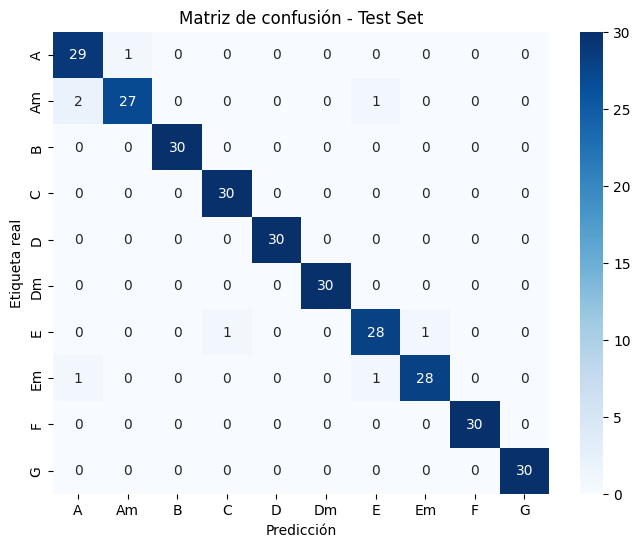

In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_classes, pred_classes)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicción")
plt.ylabel("Etiqueta real")
plt.title("Matriz de confusión - Test Set")
plt.show()


In [8]:
from sklearn.metrics import classification_report
print(classification_report(true_classes, pred_classes, target_names=class_labels))


              precision    recall  f1-score   support

           A       0.91      0.97      0.94        30
          Am       0.96      0.90      0.93        30
           B       1.00      1.00      1.00        30
           C       0.97      1.00      0.98        30
           D       1.00      1.00      1.00        30
          Dm       1.00      1.00      1.00        30
           E       0.93      0.93      0.93        30
          Em       0.97      0.93      0.95        30
           F       1.00      1.00      1.00        30
           G       1.00      1.00      1.00        30

    accuracy                           0.97       300
   macro avg       0.97      0.97      0.97       300
weighted avg       0.97      0.97      0.97       300

